In [1]:
import wandb
import numpy as np
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=13)


In [2]:
import os
os.environ.get("LD_LIBRARY_PATH")

'/eos/home-g/gkrzmanc/miniforge3/lib:/home/gkrzmanc/env/lib:'

In [65]:
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import numpy as np
import torch
print("CUDA available:", torch.cuda.is_available())  # in case needed


def get_dataset():
    path = "/afs/cern.ch/work/g/gkrzmanc/mlpf_results/clustering_gt_with_pid_and_mean_features/cluster_features"
    r = {}
    n = 0
    #nmax = 257
    for file in os.listdir(path):
        #n += 1
        #if n > nmax:
        #    break
        f = pickle.load(open(os.path.join(path, file), "rb"))
        for key in f:
            if key not in r:
                r[key] = f[key]
            else:
                r[key] = torch.concatenate((r[key], f[key]), axis=0)
    x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
    h_names = ["hit_x_avg", "hit_y_avg", "hit_z_avg"]
    h1_names = ["hit_eta_avg", "hit_phi_avg"]
    print("x shape:", r["x"].shape)
    xyz = r["node_features_avg"][:, [0,1,2]].cpu()
    eta_phi = torch.stack([calculate_eta(xyz[:, 0], xyz[:, 1], xyz[:, 2]), calculate_phi(xyz[:, 0], xyz[:, 1])], dim=1)
    return torch.concatenate([r["x"], xyz, eta_phi], dim=1), x_names + h_names + h1_names, r["true_e_corr"], r["e_true"], r["e_reco"], r["y_particles"][:, 6]


def get_split(ds):
    from sklearn.model_selection import train_test_split
    x, _, y, etrue, _, pids = ds
    xtrain, xtest, ytrain, ytest, energiestrain, energiestest, pid_train, pid_test = train_test_split(
        x, y, etrue, pids, test_size=0.2, random_state=42
    )
    return xtrain, xtest, ytrain, ytest, energiestrain, energiestest, pid_train, pid_test

def get_gb():
    from sklearn.ensemble import GradientBoostingRegressor
    model = GradientBoostingRegressor(verbose=1)
    return model

def calculate_phi(x, y):
    return np.arctan2(y, x)

def calculate_eta(x, y, z):
    theta = np.arctan2(np.sqrt(x**2 + y**2), z)
    return -np.log(np.tan(theta/2))

def get_nn():
    from sklearn.neural_network import MLPRegressor
    model = MLPRegressor(hidden_layer_sizes=(30, 30), verbose=True, max_iter=1000, batch_size=8)
    return model


def main(ds, train_only_on_tracks=False, train_only_on_neutral=False, train_energy_regression=False, train_only_on_PIDs=[], remove_sum_e=False, use_model="gradboost"):
    split = list(get_split(ds))
    if use_model == "gradboost":
        model = get_gb()
    elif use_model == "nn":
        model = get_nn()
    else:
        raise NotImplementedError
    if train_only_on_tracks:
        mask = (split[0][:, 3] > 0) & (split[0][:, 7] == 1)
        split[0] = split[0][mask]
        split[2] = split[2][mask]
        split[4] = split[4][mask]
    elif train_only_on_neutral:
        mask = (split[0][:, 3] == 0) & (split[0][:, 7] == 0)
        split[0] = split[0][mask]
        split[2] = split[2][mask]
        split[4] = split[4][mask]
    elif train_only_on_PIDs:
        mask = [i in train_only_on_PIDs for i in split[6]]
        mask = torch.tensor(mask)
        split[0] = split[0][mask]
        split[2] = split[2][mask]
        split[4] = split[4][mask]
    if remove_sum_e:
        split[0][:, 6] = 0.0  # remove the sum of the hits 
    if not train_energy_regression:
        result = model.fit(split[0], split[2])
        print("Fitted model:", result)
        # validation
        ysum = split[1][:, 6]
        ypred = model.predict(split[1])
        epred = ysum * (1 + ypred)
        ytrue = split[3]
        energies = split[5]
        return ytrue, epred, energies, split[1], model, split
    else:
        result = model.fit(split[0], split[4])
        print("Fitted model:", result)
        # validation
        epred = model.predict(split[1])
        ytrue = split[3]
        ysum = split[1][:, 6]
        ypred = epred / ysum - 1
        energies = split[5]
        return ytrue, epred, energies, split[1], model, split
        # log scatterplots of validation results per energy
    #else:
    #    raise NotImplementedError



CUDA available: True


In [4]:
ds = get_dataset()
print("Loaded dataset")

x shape: torch.Size([123944, 8])
Loaded dataset


In [5]:
yt, yp, en, _, model, split = main(ds=ds, train_energy_regression=False, train_only_on_PIDs=[211], remove_sum_e=False)

      Iter       Train Loss   Remaining Time 
         1           3.0837            3.25s
         2           2.5693            3.07s
         3           2.1499            2.99s
         4           1.8082            2.92s
         5           1.5317            2.87s
         6           1.3045            2.84s
         7           1.1196            2.81s
         8           0.9688            2.77s
         9           0.8454            2.74s
        10           0.7449            2.70s
        20           0.3496            2.38s
        30           0.2436            2.13s
        40           0.2093            1.91s
        50           0.1299            1.67s
        60           0.0943            1.32s
        70           0.0768            0.98s
        80           0.0607            0.65s
        90           0.0487            0.33s
       100           0.0419            0.00s
Fitted model: GradientBoostingRegressor(verbose=1)


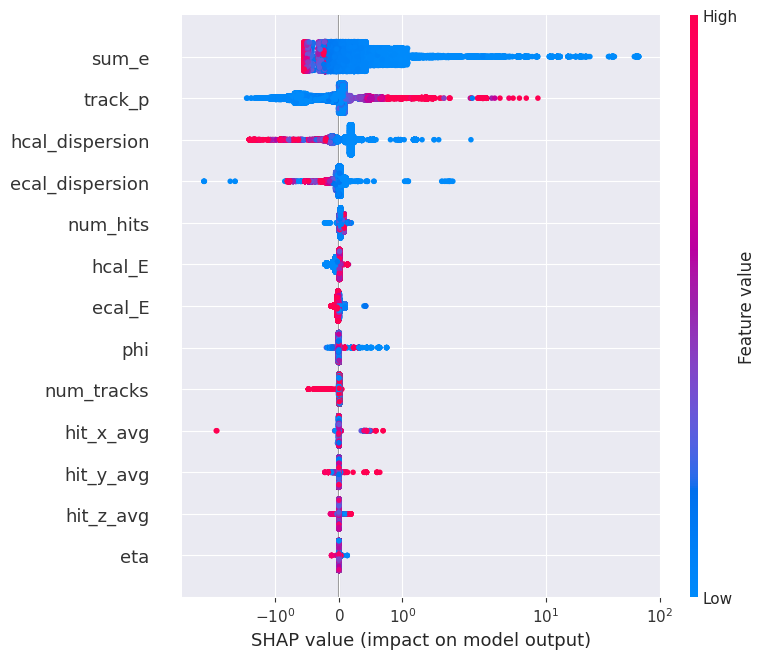

In [41]:
import shap
import numpy as np

te = shap.TreeExplainer(model)
shap_vals_r = te.shap_values(np.array(split[1]))
x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
h_names = ["hit_x_avg", "hit_y_avg", "hit_z_avg", "eta", "phi"]
shap.summary_plot(shap_vals_r, split[1], feature_names=x_names+h_names, use_log_scale=True, show=False)
#plt.savefig("/eos/user/g/gkrzmanc/2024/12_3_/shap_summary_tracks_Regression_with_XYZ.pdf")
plt.show()

In [78]:
import numpy as np
def get_std68(theHist, bin_edges, percentage=0.683, epsilon=0.01):
    # theHist, bin_edges = np.histogram(data_for_hist, bins=bins, density=True)
    wmin = 0.2
    wmax = 1.0

    weight = 0.0
    points = []
    sums = []

    # fill list of bin centers and the integral up to those point
    for i in range(len(bin_edges) - 1):
        weight += theHist[i] * (bin_edges[i + 1] - bin_edges[i])
        points.append([(bin_edges[i + 1] + bin_edges[i]) / 2, weight])
        sums.append(weight)
    low = wmin
    high = wmax
    width = 100
    for i in range(len(points)):
        for j in range(i, len(points)):
            wy = points[j][1] - points[i][1]
            if abs(wy - percentage) < epsilon:
                wx = points[j][0] - points[i][0]
                if wx < width:
                    low = points[i][0]
                    high = points[j][0]
                    width = wx

    return 0.5 * (high - low), low, high

def mean_without_outliers(data):
    remove_count = int(len(data) * 0.01)
    # Sort the array
    sorted_arr = np.sort(data)
    # Remove the lowest and highest 1% of the elements
    trimmed_arr = sorted_arr[remove_count:-remove_count]
    # Calculate the mean of the trimmed array
    mean = np.mean(trimmed_arr)
    return mean

def obtain_MPV_and_68_raw(data_for_hist, bins_per_binned_E=np.arange(-1, 5, 0.01), epsilon=0.01):
    hist, bin_edges = np.histogram(data_for_hist, bins=bins_per_binned_E, density=True)
    ind_max_hist = np.argmax(hist)
    #MPV = (bin_edges[ind_max_hist] + bin_edges[ind_max_hist + 1]) / 2
    std68, low, high = get_std68(hist, bin_edges, epsilon=epsilon)
    MPV = mean_without_outliers(data_for_hist)
    return MPV, std68, low, high

def obtain_MPV_and_68(data_for_hist, *args, **kwargs):
    # trim the data for hist by removing the top and bottom 1%
    if len(data_for_hist) != 0:
        data_for_hist = data_for_hist[(data_for_hist > np.percentile(data_for_hist, 1)) & (data_for_hist < np.percentile(data_for_hist, 99))]
    # bins_per_binned_E = np.linspace(data_for_hist.min(), data_for_hist.max(), 1000)
    bins_per_binned_E = np.arange(0, 2, 1e-3)
    return obtain_MPV_and_68_raw(data_for_hist, bins_per_binned_E)
    

In [89]:
def get_charged_response_resol_plot_for_PID(pid, yt, yp, en, model, split, neutral=False):
    e_thresholds = [0, 6, 12, 18, 24, 30, 36, 42, 48]  # True E thresholds!
    mpvs_model, s68s_model = [], []
    mpvs_pandora, s68s_pandora = [], []
    mpvs_sum_hits, s68s_sum_hits = [], []
    e_true = (1+yt) * split[1][:, 6].numpy()
    e_pred = yp
    frac_pred = e_pred / e_true
    frac_e_sum = split[1][:, 6].clone().detach().cpu().numpy() / e_true
    e_track = split[1][:, 3].clone().detach().cpu().numpy()
    frac_track = e_track / e_true
    track_filter = ((split[1][:, 3] > 0) & (split[1][:, 7] == 1))
    if neutral:
        track_filter = ~track_filter
    track_filter = track_filter & (split[-1] == pid).cpu()
    binsize = 0.01
    bins_x = []
    
    for i, e_threshold in enumerate(e_thresholds):
        if i == 0:
            continue
        bins_x.append(0.5 * (e_thresholds[i] + e_thresholds[i-1]))
        filt_energy = (e_true < e_thresholds[i]) & (e_true >= e_thresholds[i-1])
        mpv, s68, lo, hi = obtain_MPV_and_68(frac_pred[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5, binsize))
        mpvs_model.append(mpv)
        s68s_model.append(s68)
        mpv, s68, lo, hi = obtain_MPV_and_68(frac_track[filt_energy & track_filter].clip(max=5), bins_per_binned_E=np.arange(0, 5, binsize))
        mpvs_pandora.append(mpv)
        s68s_pandora.append(s68)
        mpv, s68, _, _= obtain_MPV_and_68(frac_e_sum[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5, binsize))
        mpvs_sum_hits.append(mpv)
        s68s_sum_hits.append(s68)
        
    fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) # Height of 2 subplots. 
    ax[0].plot(bins_x, np.array(s68s_model) / np.array(mpvs_model), ".--", label="GradBoost")
    ax[0].plot(bins_x, np.array(s68s_pandora) / np.array(mpvs_pandora), ".--", label="track p")
    ax[0].plot(bins_x, np.array(s68s_sum_hits) / np.array(mpvs_sum_hits), ".--", label="sum hits")
    ax[0].legend()
    ax[1].set_xlabel("Energy [GeV]")
    ax[0].set_ylabel("σ / E")
    #ax[0].set_ylim([0, 0.4])
    ax[1].plot(bins_x, mpvs_model, ".--", label="GradBoost")
    ax[1].plot(bins_x, mpvs_pandora, ".--", label="track p")
    ax[1].plot(bins_x, mpvs_sum_hits, ".--", label="sum hits")
    ax[1].set_ylim([0.95, 1.05])
    ax[1].set_ylabel("response")
    ax[0].set_title("PID: " + str(pid))
    upper_plot = {"ML": np.array(s68s_model) / np.array(mpvs_model),
                  "p": np.array(s68s_pandora) / np.array(mpvs_pandora),
                  "sum": np.array(s68s_sum_hits) / np.array(mpvs_sum_hits)}
    lower_plot = {"ML": mpvs_model, "p": mpvs_pandora, "sum": mpvs_sum_hits}
    return fig, upper_plot, lower_plot, bins_x


/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


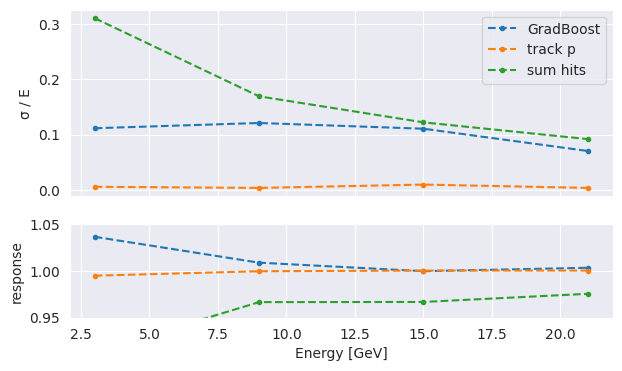

In [42]:
get_charged_response_resol_plot_for_PID(211).show()


In [87]:
def get_plots(PIDs, energy_regression=False, remove_sum_e=False, use_model="gradboost", neutral=False):
    yt, yp, en, _, model, split = main(ds=ds, train_energy_regression=energy_regression, train_only_on_PIDs=PIDs, remove_sum_e=remove_sum_e, use_model=use_model)
    import shap
    import numpy as np
    #te = shap.TreeExplainer(model)
    #shap_vals_r = te.shap_values(np.array(split[1]))
    x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
    h_names = ["hit_x_avg", "hit_y_avg", "hit_z_avg", "eta", "phi"]
    #shap.summary_plot(shap_vals_r, split[1], feature_names=x_names + h_names, use_log_scale=True, show=False)
    #plt.show()
    results = {}
    for pid in PIDs:
        fig, upper, lower, x = get_charged_response_resol_plot_for_PID(pid, yt, yp, en, model, split, neutral=neutral)
        fig.show()
        results[pid] = [upper, lower, x]
    return results

      Iter       Train Loss   Remaining Time 
         1           3.0837            3.24s
         2           2.5693            3.02s
         3           2.1499            2.92s
         4           1.8082            2.86s
         5           1.5317            2.81s
         6           1.3045            2.77s
         7           1.1196            2.74s
         8           0.9688            2.70s
         9           0.8454            2.67s
        10           0.7449            2.63s
        20           0.3496            2.30s
        30           0.2436            1.99s
        40           0.2093            1.71s
        50           0.1299            1.42s
        60           0.0943            1.13s
        70           0.0768            0.84s
        80           0.0607            0.56s
        90           0.0487            0.28s
       100           0.0419            0.00s
Fitted model: GradientBoostingRegressor(verbose=1)


/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


      Iter       Train Loss   Remaining Time 
         1         123.7052            3.13s
         2         101.1158            2.93s
         3          82.7736            2.83s
         4          67.8300            2.76s
         5          55.5738            2.72s
         6          45.5914            2.68s
         7          37.5449            2.64s
         8          30.9069            2.60s
         9          25.5138            2.56s
        10          21.1028            2.53s
        20           3.9001            2.21s
        30           1.3292            1.92s
        40           0.8325            1.64s
        50           0.6430            1.37s
        60           0.5502            1.10s
        70           0.4992            0.82s
        80           0.4596            0.55s
        90           0.4275            0.27s
       100           0.4027            0.00s
Fitted model: GradientBoostingRegressor(verbose=1)


/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Iteration 1, loss = 426.89959593
Iteration 2, loss = 27.65052399
Iteration 3, loss = 19.83387592
Iteration 4, loss = 21.83105991
Iteration 5, loss = 15.55804050
Iteration 6, loss = 15.06133085
Iteration 7, loss = 16.42814174
Iteration 8, loss = 7.58885738
Iteration 9, loss = 10.19949377
Iteration 10, loss = 8.34374441
Iteration 11, loss = 5.11207865
Iteration 12, loss = 5.72679450
Iteration 13, loss = 5.73915031
Iteration 14, loss = 4.58481738
Iteration 15, loss = 3.78008111
Iteration 16, loss = 3.64493903
Iteration 17, loss = 3.80095045
Iteration 18, loss = 2.77065621
Iteration 19, loss = 2.70393218
Iteration 20, loss = 2.55955139
Iteration 21, loss = 2.27394893
Iteration 22, loss = 2.35078231
Iteration 23, loss = 2.15993547
Iteration 24, loss = 2.03820077
Iteration 25, loss = 1.97396293
Iteration 26, loss = 1.89067489
Iteration 27, loss = 1.86554136
Iteration 28, loss = 1.82341720
Iteration 29, loss = 1.79200830
Iteration 30, loss = 1.77872308
Iteration 31, loss = 1.79724378
Iteratio

/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


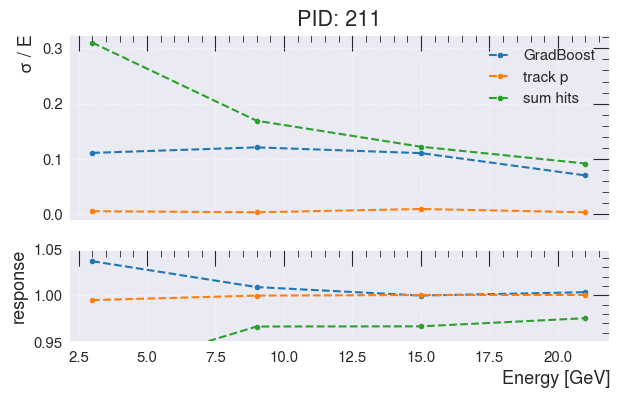

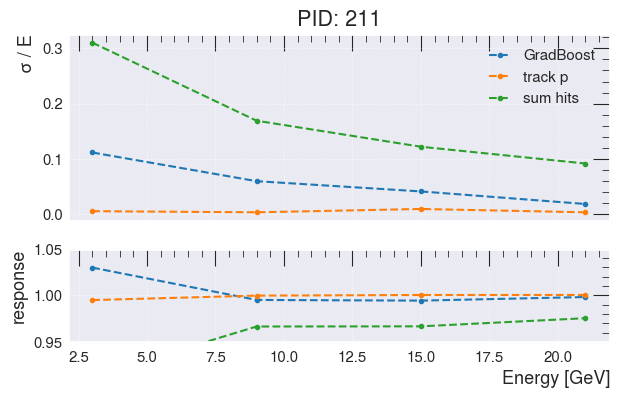

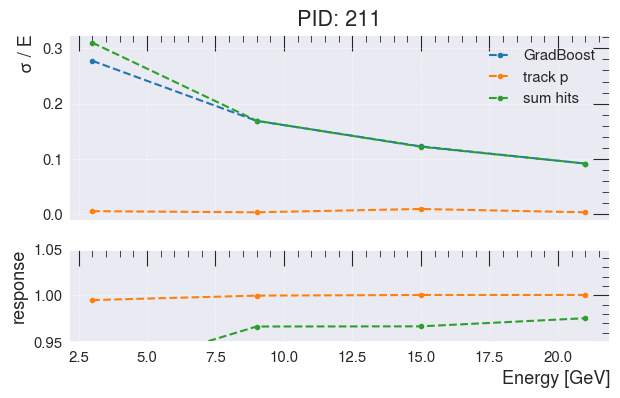

In [80]:
res_cf_regress = get_plots([211], energy_regression=False)[211]
res_energy_regress = get_plots([211], energy_regression=True)[211]
res_cf_regress_NN = get_plots([211], energy_regression=False, use_model="nn")[211]

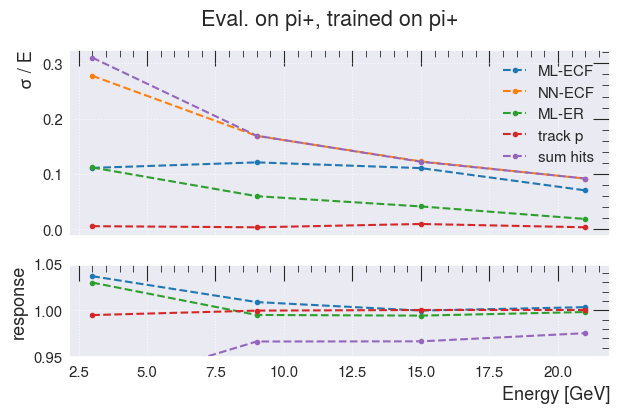

In [81]:

fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) # Height of 2 subplots.
bins_x = res_cf_regress[2]
upper_curve_cf = res_cf_regress[0]["ML"]
upper_curve_energy = res_energy_regress[0]["ML"]
upper_curve_pandora  = res_energy_regress[0]["p"]
upper_curve_sum_hits = res_energy_regress[0]["sum"]
response_cf = res_cf_regress[1]["ML"]
response_energy = res_energy_regress[1]["ML"]
response_pandora = res_energy_regress[1]["p"]
response_sumhits = res_energy_regress[1]["sum"]

ax[0].plot(bins_x, upper_curve_cf, ".--", label="ML-ECF")
ax[0].plot(bins_x, res_cf_regress_NN[0]["ML"], ".--", label="NN-ECF")
ax[0].plot(bins_x, upper_curve_energy, ".--", label="ML-ER")
ax[0].plot(bins_x, upper_curve_pandora, ".--", label="track p")
ax[0].plot(bins_x, upper_curve_sum_hits, ".--", label="sum hits")
ax[0].legend()
ax[0].set_ylabel("σ / E")
ax[1].plot(bins_x, response_cf, ".--", label="ML-ECF")
ax[1].set_xlabel("Energy [GeV]")
ax[1].plot(bins_x, res_cf_regress_NN[1]["ML"], ".--", label="NN-ECF")
ax[1].plot(bins_x, response_energy, ".--", label="ML-ER")
ax[1].plot(bins_x, response_pandora, ".--", label="track p")
ax[1].plot(bins_x, response_sumhits, ".--", label="sum hits")
ax[1].set_ylim([0.95, 1.05])
ax[1].set_ylim([0.95, 1.05])
ax[1].set_ylabel("response")

fig.suptitle("Eval. on pi+, trained on pi+")
fig.show()

In [41]:
upper_curve_energy

array([0.11140527, 0.12091326, 0.11051318, 0.07025302,        nan,
              nan,        nan,        nan])

In [13]:
res_energy_regress[1].keys()

dict_keys(['ML', 'p', 'sumhits'])

In [ ]:
neutrals = {
    "gamma": 22,
    "Klong": 130,
    "n": 2112
}
charged = {
    "pi+": 211,
    "pi-": -211,
    "p": 2212,
    "pbar": -2212,
    "e": 11
}


In [ ]:
for key in neutrals:
    fig = get_neutral_response_resolution_plot_for_PID(neutrals[key])
    fig.suptitle(key)
    fig.savefig(f"/eos/user/g/gkrzmanc/2024/19_3_/response_and_resolution_plots_smooth_mean_{key}.pdf")
    fig.show()

In [ ]:
for key in charged:
    fig = get_charged_response_resol_plot_for_PID(charged[key])
    fig.suptitle(key)
    fig.savefig(f"/eos/user/g/gkrzmanc/2024/19_3_/response_and_resolution_tracks_smooth_mean_{key}.pdf")
    fig.show()


      Iter       Train Loss   Remaining Time 
         1           5.9503            6.61s
         2           5.0028            6.15s
         3           4.2344            5.94s
         4           3.6100            5.81s
         5           3.0989            5.69s
         6           2.6851            5.59s
         7           2.3219            5.50s
         8           2.0446            5.42s
         9           1.8191            5.34s
        10           1.6271            5.27s
        20           0.8258            4.64s
        30           0.6219            4.04s
        40           0.5657            3.45s
        50           0.4472            2.86s
        60           0.3907            2.29s
        70           0.3674            1.71s
        80           0.3365            1.14s
        90           0.2955            0.57s
       100           0.2867            0.00s
Fitted model: GradientBoostingRegressor(verbose=1)
tensor(2252) 6


/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


tensor(624) 12
tensor(348) 18
tensor(245) 24
tensor(177) 30
tensor(184) 36
tensor(153) 42
tensor(123) 48
      Iter       Train Loss   Remaining Time 
         1         125.4646            6.08s
         2         102.6794            5.80s
         3          84.1331            5.70s
         4          69.1067            5.59s
         5          56.8805            5.48s
         6          46.9659            5.38s
         7          38.8862            5.29s
         8          32.3261            5.21s
         9          27.0009            5.14s
        10          22.6646            5.07s
        20           6.1398            4.45s
        30           3.8068            3.88s
        40           3.3330            3.32s
        50           3.1488            2.77s
        60           3.0486            2.22s
        70           2.9665            1.66s
        80           2.8909            1.11s
        90           2.8398            0.56s
       100           2.7409            

/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


tensor(624) 12
tensor(348) 18
tensor(245) 24
tensor(177) 30
tensor(184) 36
tensor(153) 42
tensor(123) 48
Iteration 1, loss = 135.76277508
Iteration 2, loss = 20.45309649
Iteration 3, loss = 15.37221523
Iteration 4, loss = 11.76694376
Iteration 5, loss = 8.56260902
Iteration 6, loss = 6.72780075
Iteration 7, loss = 5.73819560
Iteration 8, loss = 5.00602351
Iteration 9, loss = 4.19076093
Iteration 10, loss = 3.77098045
Iteration 11, loss = 3.59789254
Iteration 12, loss = 3.53352440
Iteration 13, loss = 3.51696425
Iteration 14, loss = 3.50224114
Iteration 15, loss = 3.45355890
Iteration 16, loss = 3.39539105
Iteration 17, loss = 3.29070610
Iteration 18, loss = 3.25640644
Iteration 19, loss = 3.24060552
Iteration 20, loss = 3.16712627
Iteration 21, loss = 3.09929755
Iteration 22, loss = 3.03483747
Iteration 23, loss = 3.03277912
Iteration 24, loss = 3.00331634
Iteration 25, loss = 2.99178276
Iteration 26, loss = 2.84530490
Iteration 27, loss = 2.90202396
Iteration 28, loss = 2.87343975
Ite

/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


tensor(624) 12
tensor(348) 18
tensor(245) 24
tensor(177) 30
tensor(184) 36
tensor(153) 42
tensor(123) 48


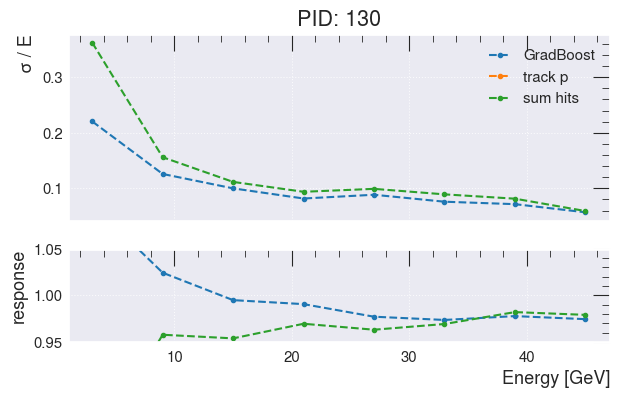

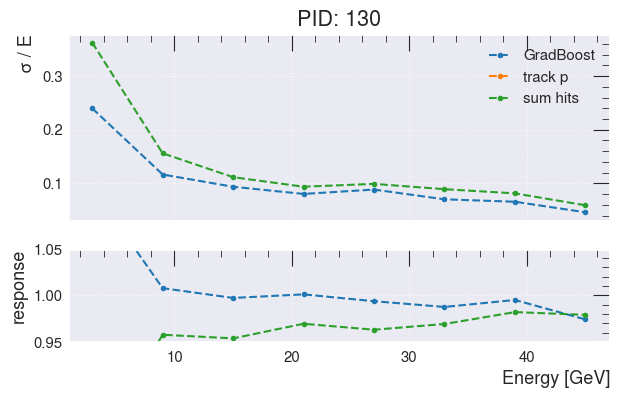

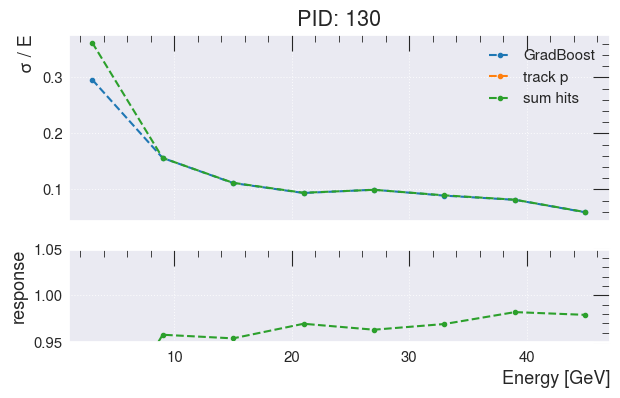

In [90]:

res_cf_regress_Klong = get_plots([130], energy_regression=False, neutral=True)[130]
res_energy_regress_Klong = get_plots([130], energy_regression=True, neutral=True)[130]
res_cf_regress_NN_Klong = get_plots([130], energy_regression=False, use_model="nn", neutral=True)[130]


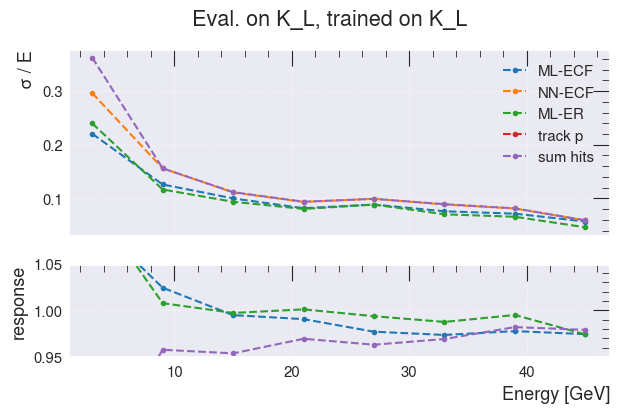

In [92]:

fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) # Height of 2 subplots.
bins_x = res_cf_regress_Klong[2]
upper_curve_cf = res_cf_regress_Klong[0]["ML"]
upper_curve_energy = res_energy_regress_Klong[0]["ML"]
upper_curve_pandora  = res_energy_regress_Klong[0]["p"]
upper_curve_sum_hits = res_energy_regress_Klong[0]["sum"]
response_cf = res_cf_regress_Klong[1]["ML"]
response_energy = res_energy_regress_Klong[1]["ML"]
response_pandora = res_energy_regress_Klong[1]["p"]
response_sumhits = res_energy_regress_Klong[1]["sum"]

ax[0].plot(bins_x, upper_curve_cf, ".--", label="ML-ECF")
ax[0].plot(bins_x, res_cf_regress_NN_Klong[0]["ML"], ".--", label="NN-ECF")
ax[0].plot(bins_x, upper_curve_energy, ".--", label="ML-ER")
ax[0].plot(bins_x, upper_curve_pandora, ".--", label="track p")
ax[0].plot(bins_x, upper_curve_sum_hits, ".--", label="sum hits")
ax[0].legend()
ax[0].set_ylabel("σ / E")
ax[1].plot(bins_x, response_cf, ".--", label="ML-ECF")
ax[1].set_xlabel("Energy [GeV]")
ax[1].plot(bins_x, res_cf_regress_NN_Klong[1]["ML"], ".--", label="NN-ECF")
ax[1].plot(bins_x, response_energy, ".--", label="ML-ER")
ax[1].plot(bins_x, response_pandora, ".--", label="track p")
ax[1].plot(bins_x, response_sumhits, ".--", label="sum hits")
ax[1].set_ylim([0.95, 1.05])
ax[1].set_ylim([0.95, 1.05])
ax[1].set_ylabel("response")

fig.suptitle("Eval. on K_L, trained on K_L")
fig.show()